# Shanon entropy - All channels and all freq bands in One model

Trial counts per class: {'AD': 1352, 'normal': 1677, 'MCI': 848}
trial number to balance classes: 848
3 * 848 =  2544
we used random selection of trials to balance classes
Final balanced dataset:
Data shape: (2544, 4, 600)
Labels shape: (2544,)
Labels: (array(['AD', 'MCI', 'normal'], dtype='<U6'), array([848, 848, 848]))

=== Evaluating Shannon Entropy Features with 10-Fold Cross-Validation ===
Feature matrix shape: (2544, 20)

=== Classifier Performance (10-fold Accuracy) ===
SVM: 0.601 ± 0.027
Random Forest: 0.627 ± 0.018
Naive Bayes: 0.489 ± 0.017
Logistic Regression: 0.544 ± 0.032
Decision Tree: 0.504 ± 0.030


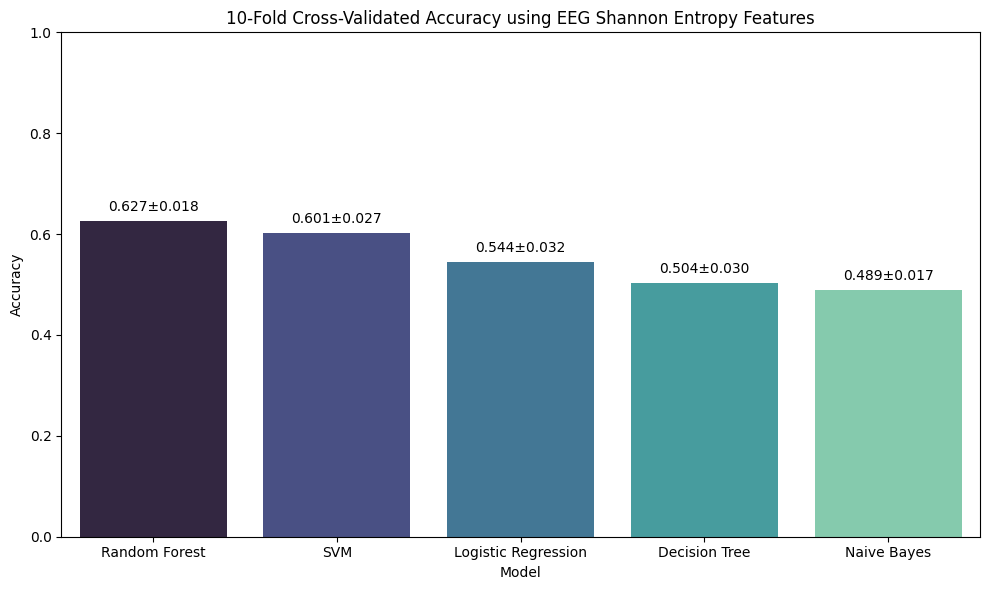

In [1]:
import scipy.io
import os
import numpy as np
import random
from scipy.stats import entropy
from scipy.signal import butter, filtfilt

# Define the main path and file paths
main_path = r'D:\Fateme A\23_Brain Electrophysiological Recording during Olfactory Stimulation in Mild Cognitive Impairment and Alzheimer Disease Patients An EEG Dataset'

# Define file names
file_paths = {
    "AD": os.path.join(main_path, "AD.mat"),
    "normal": os.path.join(main_path, "normal.mat"),
    "MCI": os.path.join(main_path, "MCI.mat")
}

# Prepare storage per class
class_data = {
    "AD": [],
    "normal": [],
    "MCI": []
}

# Load and organize all trials by class
for label, file_path in file_paths.items():
    mat_data = scipy.io.loadmat(file_path)
    eeg_data = mat_data[label]  # Assuming variable name matches label

    for patient_id in range(eeg_data.shape[1]):  # shape: (1, N_patients)
        patient_data = eeg_data[0][patient_id]
        trials = patient_data[0]  # shape: channels x samples x trials

        # Split into individual trials and add to class list
        for i in range(trials.shape[2]):
            class_data[label].append(trials[:, :, i])  # One trial

# Calculate total trial counts per class
trial_counts = {label: len(trials) for label, trials in class_data.items()}
print("Trial counts per class:", trial_counts)

# Find the minimum number of trials across the 3 classes
min_trial_count = min(trial_counts.values())
print("trial number to balance classes:", min_trial_count)

# Randomly select min_trial_count trials from each class
balanced_data = []
balanced_labels = []

for label in class_data:
    selected_trials = random.sample(class_data[label], min_trial_count)
    balanced_data.extend(selected_trials)
    balanced_labels.extend([label] * min_trial_count)

# Convert to arrays
data_array = np.stack(balanced_data)  # shape: total_trials x channels x samples
labels_array = np.array(balanced_labels)

# Final output info
print("3 * 848 = ", data_array.shape[0])
print('we used random selection of trials to balance classes')

print("Final balanced dataset:")
print("Data shape:", data_array.shape)
print("Labels shape:", labels_array.shape)
print("Labels:", np.unique(labels_array, return_counts=True))


# ===== SHANNON ENTROPY FEATURE EXTRACTION =====

def compute_shannon_entropy(signal, bins=100):
    """Compute Shannon entropy of a signal (time domain) using histogram binning."""
    histogram, bin_edges = np.histogram(signal, bins=bins, density=True)
    probs = histogram / np.sum(histogram)  # Normalize to get probability distribution
    probs = probs[probs > 0]  # Remove zero entries to avoid log(0)
    return entropy(probs)

def bandpass_filter(signal, lowcut=0.1, highcut=40.0, fs=200.0, order=3):
    """Apply a Butterworth bandpass filter to a signal."""
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

bands = {
    "delta": (0.1, 4),
    "theta": (4, 8),
    "alpha": (8, 14),
    "beta": (14, 30),
    "gamma": (30, 40)
}

def extract_shannon_entropy_features(multichannel_signal):
    """
    Extract Shannon entropy features from all EEG channels in a trial.
    """
    features = []
    for channel_signal in multichannel_signal:
        filtered_signal = bandpass_filter(channel_signal, fs=200)
        for band_name, (low, high) in bands.items():
            band_signal = bandpass_filter(filtered_signal, low, high)
            band_feature = compute_shannon_entropy(band_signal)
            features.append(band_feature)
    return features


def process_data(data_array, feature_function):
    """
    Process data array and extract features using the specified feature function.
    Now uses all 4 EEG channels.
    """
    feature_list = []
    for trial_data in data_array:  # Each trial: channels x samples
        features = feature_function(trial_data)  # Process all channels
        feature_list.append(features)
    return np.array(feature_list)  # shape: (n_trials, n_channels)



# ===== MACHINE LEARNING PIPELINE =====

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline

# Define classifiers
classifiers = {
    'SVM': SVC(kernel='rbf', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(
        random_state=42,
        max_iter=1000,
        solver='lbfgs',
        tol=1e-4,
        C=1.0
    ),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

# --- Main evaluation function for Shannon entropy features
def evaluate_shannon_entropy_features(data_array, labels_array):
    print("\n=== Evaluating Shannon Entropy Features with 10-Fold Cross-Validation ===")

    # Extract features
    X = process_data(data_array, extract_shannon_entropy_features)
    print("Feature matrix shape:", X.shape)  # Should be (n_trials, 4)


    # Expand labels to match shape of X (one label per trial)
    y = labels_array  # No need to repeat since we have one feature vector per trial
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Prepare cross-validation
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    results = {}
    print("\n=== Classifier Performance (10-fold Accuracy) ===")

    for name, clf in classifiers.items():
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', clf)
        ])

        scores = cross_val_score(pipeline, X, y_encoded, cv=skf, scoring='accuracy')

        results[name] = {
            'Mean Accuracy': np.mean(scores),
            'Std Accuracy': np.std(scores),
            'All Scores': scores
        }

        print(f"{name}: {np.mean(scores):.3f} ± {np.std(scores):.3f}")

    # Plot mean accuracies
    accuracy_df = pd.DataFrame({
        'Model': list(results.keys()),
        'Mean Accuracy': [results[m]['Mean Accuracy'] for m in results],
        'Std Accuracy': [results[m]['Std Accuracy'] for m in results]
    }).sort_values(by='Mean Accuracy', ascending=False)

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        x='Model',
        y='Mean Accuracy',
        data=accuracy_df,
        hue='Model',
        palette='mako',
        legend=False
    )

    for p, (_, row) in zip(ax.patches, accuracy_df.iterrows()):
        ax.annotate(f'{row["Mean Accuracy"]:.3f}±{row["Std Accuracy"]:.3f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', xytext=(0, 5), textcoords='offset points')

    plt.title("10-Fold Cross-Validated Accuracy using EEG Shannon Entropy Features")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

    return results

# Usage:
results = evaluate_shannon_entropy_features(data_array, labels_array)